06/28/2023 10:51:37AM - __main__DEBUG: python: 3.8.10
06/28/2023 10:51:37AM - __main__DEBUG: opencv: 4.7.0


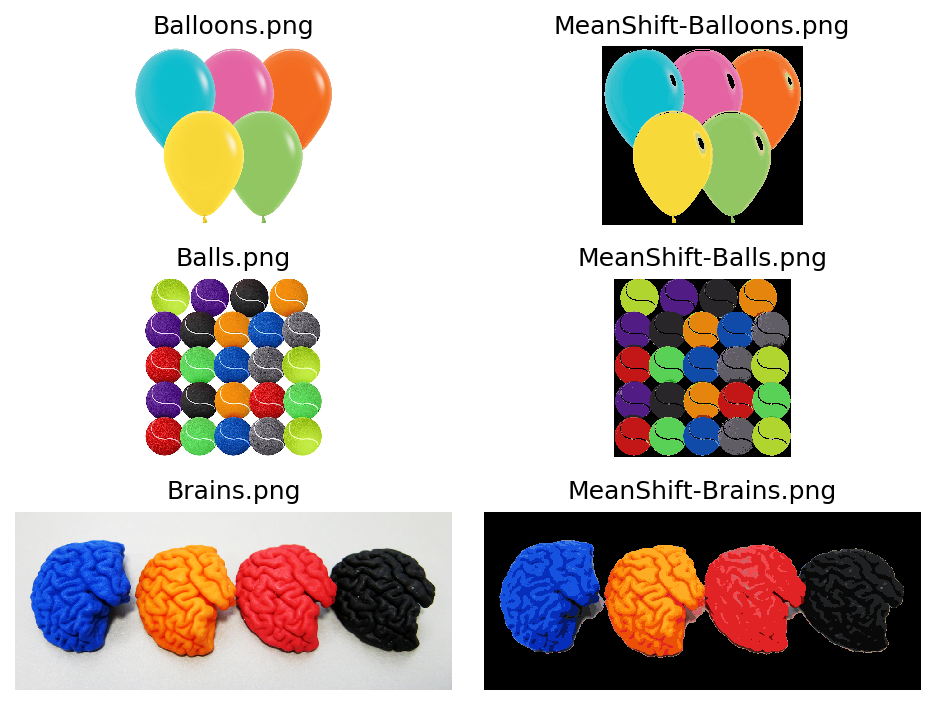

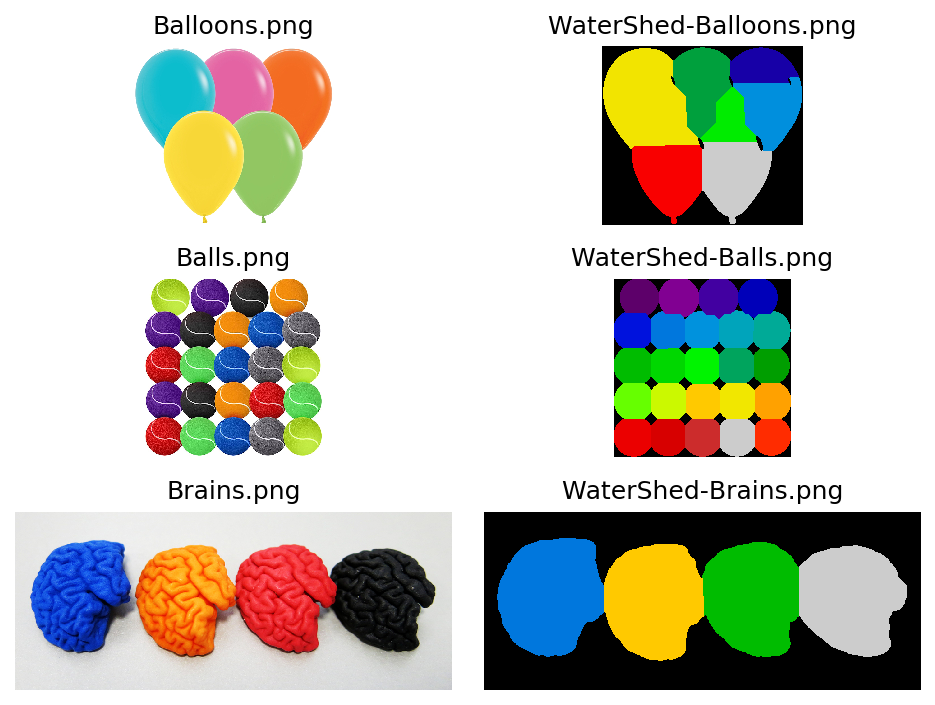

Image                #Objects Meanshift   #Objects Watershed  
Balloons                      57                   8          
Balls                         24                   25         
Brains                        33                   5          
Meanshift works well for images that have objects of interest with distinct colour intensities.
In 'Balloons', the objects have areas of white in and around them (i.e. scattered) that differ from their 'base' colour. This leads to false positives.
In 'Balls', the areas of white/texture in the objects are localised whilst the rest of the object is of a distinct colour.
In 'Brains', whilst the objects are distinct colours, they cast shadows of varying intensities, which are falsely picked up as objects.
Watershed works best for images that that have objects separated by distinct colour intensities.
In 'Balloons', adjacent objects are all of distinct colours. However, the white around their boundaries are falsely picked up as objects.
In 'Ba

In [1]:
import pathlib
import os
import sys
import subprocess
import logging
import platform
import math

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.cluster import MeanShift, estimate_bandwidth 
from skimage.color import label2rgb
from skimage.feature import peak_local_max

from skimage.segmentation import watershed
from scipy import ndimage as ndi
from scipy.ndimage import grey_closing

global global_logger

def fatal_error(msg):
  global_logger.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  global_logger.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    global_logger.debug(msg)

def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def print_histogram(img):
  final_img = img
  if len(img.shape) == 3:
    final_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  hist = cv.calcHist([final_img], [0], None, [256], [0, 256])
  plt.plot(hist)
  plt.xlim([0, 256])

def show_images(images):
  num_rows = math.ceil(len(images) / 2)

  f, ax = plt.subplots(num_rows, 2)
  ax = ax.ravel()

  for i, (title, image) in enumerate(images.items()):
    ax[i].set_title(title)
    ax[i].axis("off")

    if len(image.shape) == 3:
      # NOTE(Ryan): Convert opencv bgr to matplotlib rgb
      b, g, r = cv.split(image)
      rgb_img = cv.merge([r, g, b])
      ax[i].imshow(rgb_img)
    elif title.startswith("WaterShed"):
      ax[i].imshow(image, cmap=plt.cm.nipy_spectral)
    else:
      ax[i].imshow(image, cmap='gray')

  f.tight_layout()

  # NOTE(Ryan): Making figure fullscreen dependent on matplotlib gui backend
  if not running_on_jupyter() and "ubuntu" in platform.version().lower():
    mng = plt.get_current_fig_manager()
    mng.resize(*mng.window.maxsize())

  plt.show()

def read_img(path):
  img_bgr = cv.imread(path)
  img_gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)

  return (img_bgr, img_gray)

def q1():
  images_dir="COMP9517_23T2_Lab3_Images"

  imgs_to_show = {}

  imgs_num_segments = [0] * 3

  for i, img in enumerate(["Balloons.png", "Balls.png", "Brains.png"]):
    img_bgr, img_gray = read_img(f"{images_dir}/{img}")
    w = img_bgr.shape[1]
    h = img_bgr.shape[0]

    # NOTE(Ryan): Pre-processing to reduce noise
    blur_amount = 3
    img_bgr_blurred = cv.medianBlur(img_bgr, blur_amount)

    # NOTE(Ryan): Contrast enhance
    alpha = 1.5 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    img_bgr_enhanced = cv.convertScaleAbs(img_bgr_blurred, alpha=alpha, beta=beta)

    # TODO(Ryan): Experiment with thresholding on distance transform 
    # kernel = np.ones((3,3),np.uint8)
    # morph = cv.morphologyEx(img_binary, cv.MORPH_OPEN, kernel, iterations=2)
    # morph = cv.erode(img_binary, kernel, iterations=4)
    # ret, morph = cv.threshold(distance_transform, 0.7*distance_transform.max(), 255, 0)

    flattened_img = np.reshape(img_bgr_enhanced, [-1, 3])

    bandwidth = estimate_bandwidth(flattened_img, quantile=0.06, n_samples=3000, n_jobs=-1)
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1, max_iter=800)
    labels = meanshift.fit_predict(flattened_img)

    # TODO(Ryan): morphology on labels to remove holes?
    # would have to extract binary map from label and then morph on it
    # grey_closing(label, size=(10, 10))
    labels_unique = np.unique(labels)

    imgs_num_segments[i] = len(labels_unique)

    result = np.reshape(labels, img_bgr.shape[:2])
    imgs_to_show[f"{img}"] = img_bgr
    imgs_to_show[f"MeanShift-{img}"] = label2rgb(result, img_bgr, kind="avg")

  # IMPORTANT:
  # Notice that if the methods you use do not yield a binary map, but they directly produce labelled output images, it makes no sense to apply gray-scale operations to these output images, as the gray values have no semantic meaning (they are just random labels), unlike in the original input images.
  # So in order to meaningfully apply binary morphological operations to the output images, you would need to extract the binary maps of the individual labelled regions.
  # Would have to produce binary images from labels and morph on them

  # fit_predict() equates to: self.fit(X); return self.labels_

  show_images(imgs_to_show)

  return imgs_num_segments

def q2():
  images_dir="COMP9517_23T2_Lab3_Images"

  imgs_to_show = {}
  imgs_num_segments = [0] * 3

  for i, img in enumerate(["Balloons.png", "Balls.png", "Brains.png"]):
    img_bgr, img_gray = read_img(f"{images_dir}/{img}")
    w = img_bgr.shape[1]
    h = img_bgr.shape[0]

    # NOTE(Ryan): Contrast enhance
    alpha = 1.5 # Contrast control (1.0-3.0)
    beta = 0 # Brightness control (0-100)
    adjusted = cv.convertScaleAbs(img_bgr, alpha=alpha, beta=beta)
    img_gray = cv.cvtColor(adjusted, cv.COLOR_BGR2GRAY)

    # NOTE(Ryan): Noise removal
    blur_size = (19, ) * 2
    img_gray = cv.GaussianBlur(img_gray, blur_size, 0)

    ret, img_binary = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_TRIANGLE)

    # print_histogram(img_gray)

    distance_transform = ndi.distance_transform_edt(img_binary) 

    # NOTE(Ryan): These are pixels that are the furthest away from the background
    region_size= (64, ) * 2
    coords = peak_local_max(distance_transform, footprint=np.ones(region_size), labels=img_binary)
    mask = np.zeros(distance_transform.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask) 
    labels = watershed(-distance_transform, markers, mask=img_binary)
    unique_labels = np.unique(labels)
    num_unique_labels = len(unique_labels)

    imgs_num_segments[i] = num_unique_labels

    imgs_to_show[f"{img}"] = img_bgr
    imgs_to_show[f"WaterShed-{img}"] = labels 

  show_images(imgs_to_show)

  return imgs_num_segments

def q3(mean_shift, watershed):
  print(f"{'Image': <20} {'#Objects Meanshift': <20} {'#Objects Watershed': <20}")
  print("=" * 60)
  print(f"{'Balloons':<20} {mean_shift[0]:^20} {watershed[0]:^20}")
  print(f"{'Balls':<20} {mean_shift[1]:^20} {watershed[1]:^20}")
  print(f"{'Brains':<20} {mean_shift[2]:^20} {watershed[2]:^20}")

#|| Image                #Objects Meanshift   #Objects Watershed  
#|| ============================================================
#|| Balloons(5)                      57                   8          
#|| Balls(24)                        24                   25         
#|| Brains(4)                        33                   5          
  print(f"Meanshift works well for images that have objects of interest with distinct colour intensities.")
  print(f"In 'Balloons', the objects have areas of white in and around them (i.e. scattered) that differ from their 'base' colour. This leads to false positives.")
  print(f"In 'Balls', the areas of white/texture in the objects are localised whilst the rest of the object is of a distinct colour.")
  print(f"In 'Brains', whilst the objects are distinct colours, they cast shadows of varying intensities, which are falsely picked up as objects.")

  print(f"Watershed works best for images that that have objects separated by distinct colour intensities.")
  print(f"In 'Balloons', adjacent objects are all of distinct colours. However, the white around their boundaries are falsely picked up as objects.")
  print(f"In 'Balls' and 'Brains', adjacent objects are all of distinct colours.")

  print(f"Therefore, meanshift works best for 'Balls' and watershed works best for 'Balloons' and 'Brains'.")

def main(): 
  trace(f"opencv: {cv.__version__}")
  mpl.rcParams['figure.dpi']= 150

  # mean_shift_objects = [10, 20, 30]
  # watershed_objects = [40, 50, 60]

  mean_shift_objects = q1()
  #print(mean_shift_objects)
  watershed_objects = q2()
  #print(watershed_objects)

  q3(mean_shift_objects, watershed_objects)


def running_on_jupyter():
  try:
    shell_name = get_ipython().__class__.__name__ 
    if shell_name == "ZMQInteractiveShell":
      return True
    else:
      return False
  except NameError:
      return False


if __name__ == "__main__":
  if not running_on_jupyter():
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
    if sys.gettrace() is None:
      os.environ["PYTHONBREAKPOINT"] = "0"
    directory_of_running_script = pathlib.Path(__file__).parent.resolve()
    os.chdir(directory_of_running_script)

  global_logger = logging.getLogger(__name__)
  global_logger.setLevel(logging.DEBUG)
  global_logger_handler = logging.StreamHandler()
  global_logger_handler.setLevel(logging.DEBUG)
  global_logger_formatter = logging.Formatter('%(asctime)s - %(name)s%(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S%p')
  global_logger_handler.setFormatter(global_logger_formatter)
  global_logger.addHandler(global_logger_handler)

  trace(f"python: {platform.python_version()}")

  main()
